# Experiments with Trustchain Data

In [1071]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np
import ast
import pandas as pd
import io
from random import random

## Used Functions

In [1081]:
def compress_blocks(blocks):
    """
    Compress blocks -> is a seqencing algorithm in a nutshell 
    """
    array = [0 for _ in range(200)]
    for b in blocks:
        for i in range (b[0], b[1]+1):
            array[i] = 1
    new_blocks = []
    last_open = 0
    opened_block = False
    last_closed = 0
    for k in range(200):
        if array[k] == 1:
            if not opened_block:
                opened_block = True
                last_open = k
            last_closed = k 
        else:
            if opened_block:
                opened_block = False
                new_blocks.append((last_open, last_closed))
    return new_blocks, array

def find_last_sig_bit(mask):
    """
    Used to find holes
    """
    index = len(mask)-1
    while not mask[index]:
        index -= 1
    return index

def create_world_knowledge(peer_id, tx_store, inv_seen):
    # all transactions seen by 
    peer_knows_peer = {}

    for tx in sorted(inv_seen[peer_id], key=lambda tx_id: (int(tx_id.split('_')[0]), int(tx_id.split('_')[1]))):
        #if int(tx.split('_')[0]) == peer_id:
        #    continue 
        # to peer knows about the from_peer
        # This is confirmation block 
        f_peer  = int(tx_store[tx]['tx']['from_peer'])
        t_peer = int(tx_store[tx]['tx']['to_peer'])
        
        if f_peer not in peer_knows_peer.keys():
            peer_knows_peer[f_peer] = {}
        if t_peer not in peer_knows_peer.keys():
            peer_knows_peer[t_peer] = {}
        
        if 'link' not in tx_store[tx].keys():
            # The transaction was never confirmed by counterparty - potentially not seen! 
            continue
        if t_peer not in peer_knows_peer[f_peer].keys():
            peer_knows_peer[f_peer][t_peer] = set()

        if f_peer not in peer_knows_peer[t_peer].keys():
            peer_knows_peer[t_peer][f_peer] = set()
        peer_knows_peer[f_peer][t_peer].add(tx_store[tx]["seq"])
        peer_knows_peer[t_peer][f_peer].add(tx_store[tx]["link"])        
        
    return peer_knows_peer

def enchance_dataset(inverted_seen, tx_store, window):
    """
    Enchance dataset with validation protocol 
    """
    import copy
    new_inverted_seen = copy.deepcopy(inverted_seen)
    num_not_seen = 0
    num_not_seen_link = 0
    num_unconfirmed = 0
    added_tx = 0
    
    for t in tx_store.values():
        t_peer = int(t['tx']['to_peer'])
        f_peer = int(t['tx']['from_peer'])
        
        if 'seq' not in t.keys():
            print(t)
            
        seq = int(t['seq'])
            
        if 'link' not in t.keys():
            num_unconfirmed += 1
            continue
            
        link = int(t['link'])    

        if str(f_peer)+"_"+str(seq) in inverted_seen[t_peer]:
            for i in range(max(1, seq-window), seq):
                k1 = str(f_peer)+"_"+str(i)
                if k1 not in new_inverted_seen[t_peer]:
                    new_inverted_seen[t_peer].add(k1)
                    added_tx+=1
        else:
            num_not_seen+=1

        if str(t_peer)+"_"+str(link) in inverted_seen[f_peer]:
            for i in range(max(1, link-window), link):
                k1 = str(t_peer)+"_"+str(i)
                if k1 not in new_inverted_seen[f_peer]:
                    new_inverted_seen[f_peer].add(k1)
                    added_tx+=1
        else:
            num_not_seen_link += 1  
            
    print("Transactions never seen by linked peer: %s; Link block never seen by source peer %s,\n \
          uncofirmed trnsactions %s" % (num_not_seen, num_not_seen_link, num_unconfirmed))
    print("Number of transactions added ", added_tx)
    return new_inverted_seen

def create_inp(peer_knowledge, target_peer, window):
    """
    Create knowledge with window verification
    """
    if target_peer not in peer_knowledge.keys():
        return None
    else:
        peers_labels = peer_knowledge[target_peer].keys()
        peers_num =  len(peer_knowledge[target_peer].keys())
        
        inp = ""
        full_mask = [0 for _ in range(200)]

        for p in peers_labels:
            blocks = [(max(k-window, 1),k) for k in peer_knowledge[target_peer][p]]
            new_blocks, array_mask = compress_blocks(blocks)
            full_mask = np.logical_or(full_mask, array_mask)
            for b in new_blocks:
                inp = inp + str(p) + str(",") + str(b[0])+str(",")+str(b[1])+str(",")+str("In") + "\n"

        last_index = find_last_sig_bit(full_mask)
        full_mask = full_mask[:last_index]
        holes = np.where(full_mask == False)[0][1:]

        return (inp, holes)

def show_peer_dna(inp):
    df = pd.read_csv(io.StringIO(inp), header=None, names=["Task", "Start", "Finish", "Resource"] )
    df["Diff"] = df.Finish - df.Start

    color = {"In":"crimson", "Out":"crimson"}
    fig,ax=plt.subplots(figsize=(9,6))

    fig.suptitle("Peer's %s knowledge about peer %s "%(wv_peer, target_peer), fontsize=15)
    labels=[]
    for i, task in enumerate(df.groupby("Task")):
        labels.append(task[0])
        for r in task[1].groupby("Resource"):
            data = r[1][["Start", "Diff"]]
            ax.broken_barh(data.values, (i-0.4,0.6), color=color[r[0]] )

    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels) 
    ax.set_xlabel("Blocks")
    plt.tight_layout()       
    plt.show()
    
def add_edge(G: nx.Graph, wv_know, p):
    for p2 in wv_know[p].keys():
        if not G.has_edge(p2, p):
            G.add_edge(p2, p)
            add_edge(G, wv_know, p2)

def form_local_graph(peer_id, tx_store,  inverted_seen):
    local_graph = nx.Graph()
    wv_know = create_world_knowledge(peer_id, tx_store, inverted_seen)
    add_edge(local_graph, wv_know, peer_id)
    return local_graph
    

# Random broadcasting

def decide_next_peers(source, target_peer, known_graph, depth):
    next_peers = set()
    if target_peer not in known_graph:
        return next_peers

    for paths in map(lambda p:
                     map(lambda path: path[1],
                         filter(lambda path: path[1] != target_peer,
                                nx.all_simple_paths(known_graph, source=source, target=p, cutoff=depth))),
                     nx.neighbors(known_graph, target_peer)):
        next_peers |= set(paths)
    return next_peers

def broadcast(topology, initiator, depth, source, target, broadacast_fanout, random=False):
    res = set()
    if depth == 0:
        return (res,0)
    if not random:
        my_local_graph = form_local_graph(source, tx_store, inverted_seen)
        next_peers = decide_next_peers(source, target, my_local_graph, depth) - {initiator} 
    else:
        next_peers = set()
        
    if len(next_peers) < broadacast_fanout: 
        # There is not enough knowledge to make decision -> use random neighbours  
        my_neigh = set(topology[source]) - {target, initiator}
        next_peers = next_peers | set(np.random.choice(list(my_neigh), broadacast_fanout, replace=False))
    
    if len(next_peers) > broadacast_fanout:
        # There is much more peers send this round - decrease fanout for next peers 
        # Choose only broadacast_fanout
        next_peers = set(np.random.choice(list(next_peers), broadacast_fanout, replace=False))
    messages_send = 0
    for p in next_peers:
        res.add(p)
        val_res = broadcast(topology, source, depth-1, p, target, broadacast_fanout)
        res = res | val_res[0]
        messages_send += val_res[1] + 1
    return (res, messages_send)
    

    
    

## Initialize experiments dataset

In [1116]:

def calc_diff(vec1, vec2, ids1, ids2):
    if not np.array_equal(ids1, ids2):     
        iter_set = ids2
        main_set = ids1
        
        main_vec = vec1
        sub_vec = vec2
        
        if len(ids1) < len(ids2):
            iter_set = ids1
            main_set = ids2
            
            main_vec = vec2
            sub_vec = vec1
            
            print("Main set is 2 vector")
        else:
            print("Main set is 1 vector")
            
        ix = np.isin(main_set, iter_set)
        vals = np.where(ix)
        
        vec3 = main_vec[vals] - sub_vec       
    else:
        print("Main set is 1 vector")
        vec3 = vec1-vec2
    return (np.sum(vec3), np.max(vec3), np.mean(vec3))

        

In [ ]:
res_vector_f = {}
res_vector_fr = {}
res_vector_p = {}
res_vector_pr = {}
vector_ids = {}

def get_exp_id(*vals):
    res = ""
    for v in vals:
        res = res + "_" +str(v)
    return res    



## Create transactions store from the csv file

In [1118]:
tx_store = {}
inverted_seen = {}
# Read trustchain transactions
ledger_path = "PeerTrustchainLedgers/Exp_1000_5.csv"
precent_lost = 0.5
max_time_val = 90.


with open(ledger_path) as read_file:
    first = True
    csv_reader = csv.reader(read_file)
    first = True
    for row in csv_reader:
        if first:
            first = False
        else:
            i = 0
            if 'database' in ledger_path:
                i = 1
                time = None
            else:
                time = float(row[0])
                
            tx = ast.literal_eval(row[1-i])
            seq_num = int(row[2-i])
            link = int(row[3-i])
            seen_by = int(row[4-i])
            
            if time:
                # Cut by time
                if time > (1-precent_lost)*max_time_val:
                    continue
            else:
                # Cut randomly 
                if random() < precent_lost:
                    continue
            
            if seen_by not in inverted_seen.keys():
                inverted_seen[seen_by] = set()                
            
            if link != 0:
                # This is confirmation for the transaction
                tx_id = str(tx['from_peer'])+"_"+str(link)
                try:
                    tx_store[tx_id]["seen_confirm"].add(seen_by)
                except KeyError as e:
                    tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": {seen_by}}
                    
                tx_store[tx_id]["seq"] = link
                tx_store[tx_id]["link"] = seq_num
                # Send 
                tx_id_inv = str(tx['to_peer']) + "_" + str(seq_num)
                tx_store[tx_id_inv] = tx_store[tx_id].copy()
                inverted_seen[seen_by].add(tx_id)
                inverted_seen[seen_by].add(tx_id_inv)
            else:
                tx_id = str(tx['from_peer'])+"_"+str(seq_num)
                if tx_id not in tx_store.keys():
                    tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": set()}
                tx_store[tx_id]["seq"] = seq_num
                tx_store[tx_id]["seen"].add(seen_by)
                inverted_seen[seen_by].add(tx_id)

# Read overlay connection
G = nx.Graph()
with open("PeerTrustchainLedgers/Exp_1000_5.peers.log") as read_file:
    first = True
    for vals in read_file.readlines():
        if first:
            first = False
        else:
            peer_a, peer_b = vals.split(',')
            G.add_edge(int(peer_a), int(peer_b))

## Enchance the dataset with window crawler

Crawler might be off for the peers dataset, we can emulate that peer also crawls block with a crawl window `window`


In [ ]:
# Enchance the dataset with window
window = 5
n_inv = enchance_dataset(inverted_seen, tx_store, window)
print("Total transactions", len(tx_store))

## Double Spend Experiments

We choose a source and an adversary connected to that source. The goal of adversary is to hide double spend. 
Adversary chooses another neighbour and hides the block by not broadcasting it. 
Source peer and choosen peer are honest and are trying to decrease the probability of double spend by broadcasting block to the neighbours. 

There are two possibilities for broadcasting: 

1. Informed decision using the best knowledge peer has: broadcast the blocks to the neighbours of the adversary(they are likely to be cheated)
2. Randomly broadcast the blocks 


In [1124]:
stats = {}

num_exp = 50
source = 1
adv = 950
depth = 2
random = True
fanout = 8
dataset = inverted_seen

adv_network = form_local_graph(adv, tx_store, dataset)
adv_set = set(adv_network[adv]) - {source, adv}

for source_2 in adv_set:    

    stats[source_2] = {} 
    stats[source_2]["messages"] = []
    stats[source_2]["f"] = []
    stats[source_2]["total"] = []
    stats[source_2]["f_r"] = []

    for _ in range(num_exp):
        peers_1 = broadcast(G, initiator=source, depth=depth, source=source, target=adv, broadacast_fanout=fanout, random=random)
        peers_999 = broadcast(G, initiator=source_2, depth=depth, source=source_2, target=adv, broadacast_fanout=fanout, random=random)

        stats[source_2]["messages"].append(peers_1[1])
        stats[source_2]["f"].append(len(peers_1[0] & peers_999[0]))
        stats[source_2]["total"].append(len(peers_1[0] | peers_999[0]))
        stats[source_2]["f_r"].append(len(set(G[950]) & peers_1[0] & peers_999[0]))    


## Add experiment results to vector

In [1121]:
f = 0
prefix = "50know"
experiment = prefix+get_exp_id(num_exp, source, adv, depth, fanout, random)
res_vector_f[experiment] = []
res_vector_fr[experiment] = []
res_vector_p[experiment] = []
res_vector_pr[experiment] = []
vector_ids[experiment] = []


for s in adv_set:
    el = np.array(stats[s]['f'])
    el_r = np.array(stats[s]['f_r'])

    fault = len(np.where( el > f)[0]) / float(len(el))
    fault_r = len(np.where( el_r > f)[0]) / float(len(el_r)) 
    res_vector_f[experiment].append(fault)
    res_vector_fr[experiment].append(fault_r)
    res_vector_p[experiment].append(np.median(el))
    res_vector_pr[experiment].append(np.median(el_r)) 
    vector_ids[experiment].append(s)

res_vector_f[experiment] = np.array(res_vector_f[experiment])
res_vector_fr[experiment] = np.array(res_vector_fr[experiment])
res_vector_p[experiment] = np.array(res_vector_p[experiment])
res_vector_pr[experiment] = np.array(res_vector_pr[experiment])

## Compare two vectors

In [1123]:
# The decision based on knowledge is better then random
print( " SUM                  MAX                MEAN")
val1 = '75know_50_1_950_2_8_False'
val2 = '50know_50_1_950_2_8_False'

id1 = np.array(vector_ids[val1])
id2 = np.array(vector_ids[val2])

print(calc_diff(res_vector_f[val1], res_vector_f[val2], id1, id2))
print(calc_diff(res_vector_fr[val1], res_vector_fr[val2], id1, id2))
print(calc_diff(res_vector_p[val1], res_vector_p[val2], id1, id2))
print(calc_diff(res_vector_pr[val1], res_vector_pr[val2], id1, id2))


 SUM    MAX      MEAN
Main set is 1 vector
(0.040000000000000036, 0.040000000000000036, 0.00235294117647059)
Main set is 1 vector
(2.0600000000000005, 0.52, 0.12117647058823533)
Main set is 1 vector
(-0.5, 1.0, -0.029411764705882353)
Main set is 1 vector
(3.0, 1.0, 0.17647058823529413)


In [1031]:
# The decision based on knowledge is better then random
print( " SUM    MAX      MEAN")
print(calc_diff(res_vector_f['_50_1_950_2_8_True'], res_vector_f['_50_1_950_2_8_False']))
print(calc_diff(res_vector_fr['_50_1_950_2_8_True'], res_vector_fr['_50_1_950_2_8_False']))
print(calc_diff(res_vector_p['_50_1_950_2_8_True'], res_vector_p['_50_1_950_2_8_False']))
print(calc_diff(res_vector_pr['_50_1_950_2_8_True'], res_vector_pr['_50_1_950_2_8_False']))

 SUM    MAX      MEAN
(-0.040000000000000036, 0.040000000000000036, -0.0015384615384615398)
(-9.46, 0.08000000000000002, -0.3638461538461538)
(-24.0, 1.0, -0.9230769230769231)
(-31.0, 0.0, -1.1923076923076923)


In [1021]:
print( " SUM    MAX      MEAN")
print(calc_diff(res_vector_f['_100_1_950_2_8_False'], res_vector_f['_20_1_950_2_8_False']))
print(calc_diff(res_vector_fr['_100_1_950_2_8_False'], res_vector_fr['_20_1_950_2_8_False']))
print(calc_diff(res_vector_p['_100_1_950_2_8_False'], res_vector_p['_20_1_950_2_8_False']))
print(calc_diff(res_vector_pr['_100_1_950_2_8_False'], res_vector_pr['_20_1_950_2_8_False']))

 SUM    MAX      MEAN
(0.07999999999999996, 0.08999999999999997, 0.003076923076923075)
(-0.22999999999999998, 0.21999999999999997, -0.008846153846153846)
(-0.5, 1.0, -0.019230769230769232)
(1.0, 1.0, 0.038461538461538464)


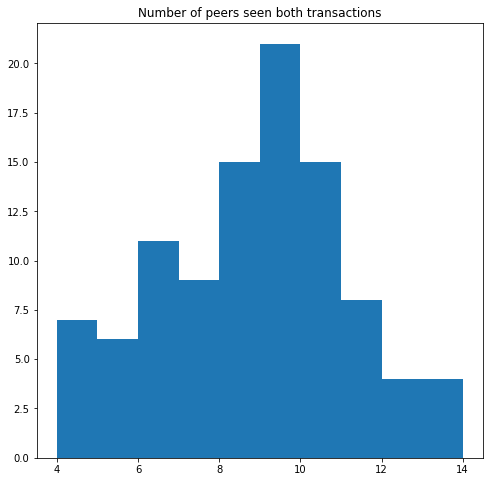

In [981]:
fig = plt.figure(3, figsize=(8,8)) 
plt.title("Number of peers seen both transactions")
plt.hist(stats["f"])
plt.show()

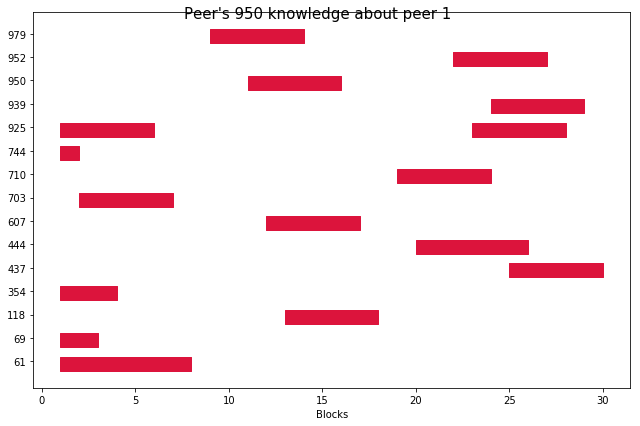

In [1126]:
# Analyse the world from the perspective of peer wv
wv_peer  = 950
# The peer who needs to be analysed 
target_peer = 1
# Validation window
window = 5

peer_knows_peer = create_world_knowledge(wv_peer, tx_store, inverted_seen)
inp = create_inp(peer_knows_peer, target_peer, window)
if inp is None:
    print("Peer is not known")
else:
    show_peer_dna(inp[0])

## Peers interaction simulation

## Set-reconcilation with cuckoo filters

### One filter per account?

The performance of the filter will degrade with more values inserted. 
To improve performance we need to introduce moving window of the elements, or limit the number of transactions. 

Filter will be filled with transaction id/hash. 

Having a filter and a new transaction one can check quickly if the transacion is inserted in the right time. 
Bloom clock 



## Transaction 

Transaction is a state transaction of a Peer A from $T_k: s_k -> s_{k+1}$. 

State can be represented as a Bloom clock? Counting Bloom Filter or Cuckoo filter

Each peer has own clock, event happend can be computed -> $H_k(B)+=1$ for each $H_k$. This will update certain cells in the clock. 

Transactions with different peers can be executed concurrently and later merged. 
